# Reading data

In [49]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

#Modelling
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

#Resampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [50]:
df = pd.read_csv('cache/data.csv', sep=',', index_col=0)
opinion_df = df[['movie_identifier','actor_identifier','identifier','actor_gender','category', 'winner', 'oscar_nominated', 'average_rating', 'number_of_votes', 'box_office_revenue']]

# Correlation

In [51]:
#Since the ratings are movie based, refactor data like so for general corellation measuring:
#Take one line for each movie. If that movie was nominated at least once, oscar_nominated = 1, else 0
nominated_movies = opinion_df[opinion_df['oscar_nominated'] == True]
#Add nominated movies to the top to ensure that the movies kept are first
each_movie_once_df = pd.concat([nominated_movies, opinion_df], axis=0)

each_movie_once_df = each_movie_once_df.drop_duplicates(subset='movie_identifier', keep='first')

[]

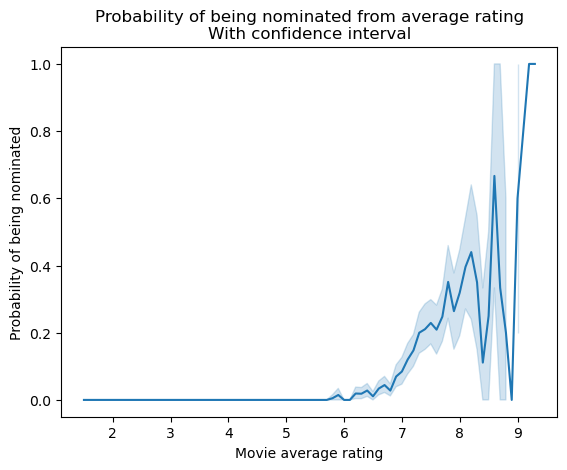

In [52]:
sns.lineplot(data=each_movie_once_df, x="average_rating", y="oscar_nominated")
plt.ylabel("Probability of being nominated")
plt.xlabel("Movie average rating")
plt.title("Probability of being nominated from average rating\nWith confidence interval")
plt.plot()

It is pretty well seen, that in general, with the average rating rising the chances to be nominated do as well. As the upper area of average ratings is rarer, the model becomes more unpredictable.

It is also noteworthy that the confindence interval when the probability of nomination is bigger is very large, meaning that the true mean of the probability could be 0 or 1. Overall though, the probability is quite clearly trending upwards with the average rating

[]

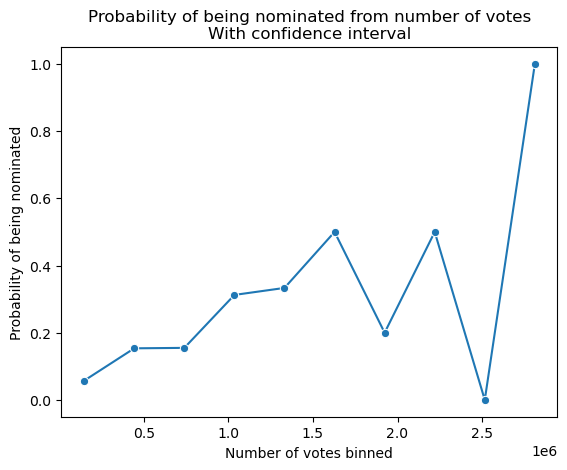

In [53]:
each_movie_once_df['binned_nr_votes'] = pd.cut(each_movie_once_df['number_of_votes'], bins=10)
binned_data = each_movie_once_df.groupby('binned_nr_votes', observed=False)['oscar_nominated'].mean().reset_index()
binned_data['binned_nr_votes'] = binned_data['binned_nr_votes'].apply(lambda x: x.mid)

sns.lineplot(data=binned_data, x='binned_nr_votes', y="oscar_nominated", marker="o")
plt.ylabel("Probability of being nominated")
plt.xlabel("Number of votes binned")
plt.title("Probability of being nominated from number of votes\nWith confidence interval")
plt.plot()

Notebly the number of votes a movie got also seems to be positively correlated with its odds of being nominated. This is likely due to the movies nominated having a lot of publicity and hence receiving more votes

[]

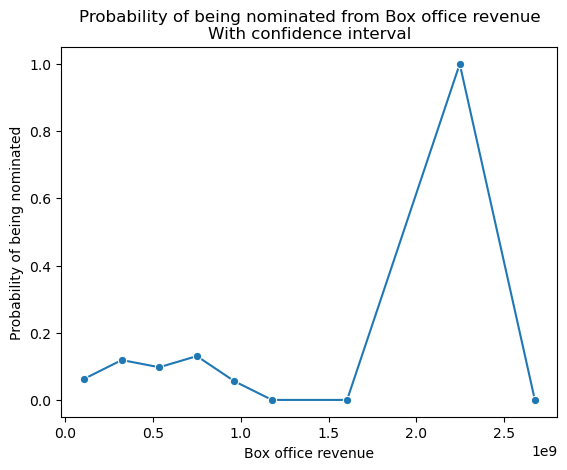

In [57]:
each_movie_once_df['binned_box_office'] = pd.cut(each_movie_once_df['box_office_revenue'], bins=13)
binned_data = each_movie_once_df.groupby('binned_box_office', observed=False)['oscar_nominated'].mean().reset_index()
binned_data['binned_box_office'] = binned_data['binned_box_office'].apply(lambda x: x.mid)

sns.lineplot(data=binned_data, x='binned_box_office', y="oscar_nominated", marker="o")
plt.ylabel("Probability of being nominated")
plt.xlabel("Box office revenue")
plt.title("Probability of being nominated from Box office revenue\nWith confidence interval")
plt.plot()

Box office score does not seem to have a huge positive correllation. Again as the high-value scores are rare, the jumps in probability are bound to happen. Though somewhat suprisingly the lower box-score movies have around equal chances of winning

# logistic regression

For seeing if a movie being nominated for an oscar is predictable from the ratings it got and the number of them, we need to use the aforementioned transformation again: each movie only has one row, and if at least one actor was nominated then the whole movie is nominated.

In [58]:
#Conducts logistic regression on the given split
def log_regression(X_train, X_test, y_train, y_test):
    # Normalize the data, fitting the scaler only to train and transforming both train and test
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    #Add constants
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    
    model = sm.Logit(y_train, X_train)
    return model.fit()

In [59]:
X = each_movie_once_df[['average_rating', 'number_of_votes', 'box_office_revenue']]
y = each_movie_once_df[['oscar_nominated']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

result = log_regression(X_train, X_test, y_train, y_test)

Optimization terminated successfully.
         Current function value: 0.177963
         Iterations 9


In [60]:
def find_optimal_cutoff(y_test, output, cutoffs):
    best_f1 = 0
    best_threshold = 0

    for cutoff in cutoffs:
        predictions = output > cutoff
        temp_f1 = sklearn.metrics.f1_score(y_test, predictions)
        if temp_f1 > best_f1:
            best_f1 = temp_f1
            best_threshold = cutoff
    print('Best threshold:', best_threshold)
    print('Best F1:', best_f1)

    predictions = output > best_threshold
    
    accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
    print('Accuracy:', accuracy)
    precision = sklearn.metrics.precision_score(y_test, predictions)
    print('Precision:', precision)
    recall = sklearn.metrics.recall_score(y_test, predictions)
    print('Recall:', recall)

In [61]:
#Evaluate
output = result.predict(sm.add_constant(X_test))

#Find the statistics with the best cutoff point
find_optimal_cutoff(y_test, output, np.linspace(0.1,1,10))

Best threshold: 0.1
Best F1: 0.14432989690721648
Accuracy: 0.0993322203672788
Precision: 0.07777777777777778
Recall: 1.0


C:\Users\rasmu\anaconda3\envs\ADA\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


The data is way too imbalanced to work. With every possible cutoff at most 1 test instance gets classified to be nominated. Attempting with data rebalancing

## With rebalanced data

### Oversampling

In [62]:
X = each_movie_once_df[['average_rating', 'number_of_votes']]
y = each_movie_once_df[['oscar_nominated']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Oversample
#At maximum triple the amount of positive samples
sampling_strategy = {False: y_train.value_counts().iloc()[0], 1: y_train.value_counts().iloc()[1] * 5}

ros = RandomOverSampler(random_state=42, sampling_strategy = sampling_strategy)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

result = log_regression(X_resampled, X_test, y_resampled, y_test)

Optimization terminated successfully.
         Current function value: 0.377511
         Iterations 7


In [63]:
#Evaluate
output = result.predict(sm.add_constant(X_test))

#Find the statistics with the best cutoff point
find_optimal_cutoff(y_test, output, np.linspace(0.1,1,10))

Best threshold: 0
Best F1: 0
Accuracy: 0.830550918196995
Precision: 0.008771929824561403
Recall: 0.01098901098901099


C:\Users\rasmu\anaconda3\envs\ADA\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Oversampling did not solve the problem, the model still predicts "not nominated" for almost all movies

### Undersampling

In [73]:
X = each_movie_once_df[['average_rating', 'number_of_votes']]
y = each_movie_once_df[['oscar_nominated']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Oversample
#Reduce the number of negative samples by 3fold
sampling_strategy = {False: y_train.value_counts().iloc()[0] // 3, 1: y_train.value_counts().iloc()[1]}
rus = RandomUnderSampler(random_state=42, sampling_strategy = sampling_strategy)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
result = log_regression(X_resampled, X_test, y_resampled, y_test)

Optimization terminated successfully.
         Current function value: 0.317936
         Iterations 8


In [74]:
y_resampled.value_counts()

oscar_nominated
False              1495
True                303
Name: count, dtype: int64

In [75]:
#Evaluate
output = result.predict(sm.add_constant(X_test))

#Find the statistics with the best cutoff point
find_optimal_cutoff(y_test, output, np.linspace(0.1,1,10))

Best threshold: 0
Best F1: 0
Accuracy: 0.7979966611018364
Precision: 0.006535947712418301
Recall: 0.01098901098901099


C:\Users\rasmu\anaconda3\envs\ADA\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Undersampling has no effect either, could be that oscar nominations are simply not linearly modellable from popular opinion.

# DecisionTree

In [76]:
def evaluate_predictions(y_test, output):
    print('Accuracy:', sklearn.metrics.accuracy_score(y_test, output))
    print('Precision:', sklearn.metrics.precision_score(y_test, output))
    print('Recall:', sklearn.metrics.recall_score(y_test, output))
    print('F1:', sklearn.metrics.f1_score(y_test, output))

In [77]:
X = each_movie_once_df[['average_rating', 'number_of_votes']]
y = each_movie_once_df[['oscar_nominated']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = tree.DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train.values.ravel())

DecisionTreeClassifier(random_state=42)

In [78]:
output = model.predict(X_test)
#Evaluation
evaluate_predictions(y_test, output)

Accuracy: 0.8948247078464107
Precision: 0.31958762886597936
Recall: 0.34065934065934067
F1: 0.32978723404255317


In [79]:
print(f"Trained model depth is {model.get_depth()} ; Number of leaves {model.get_n_leaves()}")

Trained model depth is 38 ; Number of leaves 493


Decision tree is able to solve this problem somewhat, although not with the perhaps desired accuracy. Additionally, the model trained has a huge complexity, even though it only posessed 2 features. This could indicate the model hardcoding a path for all instances and not finding any true patterns

In [80]:
#tree.plot_tree(model)

## Limiting tree depth

In [81]:
X = each_movie_once_df[['average_rating', 'number_of_votes']]
y = each_movie_once_df[['oscar_nominated']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = tree.DecisionTreeClassifier(random_state=42, max_depth=5)
model.fit(X_train, y_train.values.ravel())

DecisionTreeClassifier(max_depth=5, random_state=42)

In [82]:
output = model.predict(X_test)
#Evaluation
evaluate_predictions(y_test, output)

Accuracy: 0.9223706176961602
Precision: 0.0
Recall: 0.0
F1: 0.0


Indeed with a limited space the tree is not able to model being nominated for a oscar, indicating that this is a complex problem

# Randomforest

In [83]:
X = each_movie_once_df[['average_rating', 'number_of_votes']]
y = each_movie_once_df[['oscar_nominated']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=42)

In [84]:
output = model.predict(X_test)
#Evaluation
evaluate_predictions(y_test, output)

Accuracy: 0.9031719532554258
Precision: 0.3333333333333333
Recall: 0.27472527472527475
F1: 0.30120481927710846


Randomforest has similar predictions to decision trees. In total predicting with a 90% accuracy what movies will be nominated is not at all a bad score. However the recall and precision are not great, with only 1 in every 4 movies that are nominated caught by this model